In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!pip install pyod


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 18.8 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from pyod.models.auto_encoder import AutoEncoder


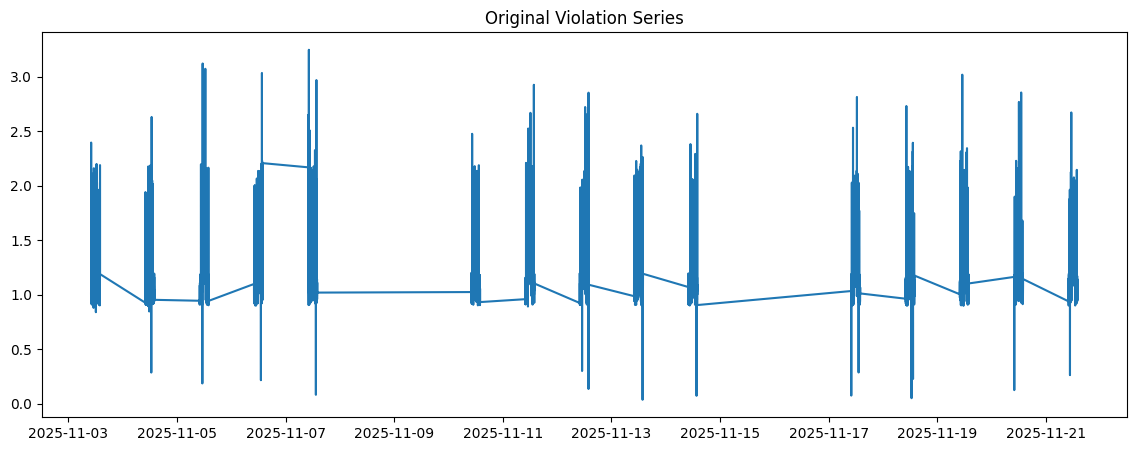

In [9]:
# 이미 앞 단계에서 생성한 파일 사용
df = pd.read_csv("/content/drive/MyDrive/violation_from_video.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

# index를 timestamp로 세팅
df = df.set_index("timestamp")

plt.figure(figsize=(14,5))
plt.plot(df.index, df["violation_level"])
plt.title("Original Violation Series")
plt.show()


In [12]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df["violation_level"].values.reshape(-1,1))


In [15]:
def create_windows(data, window=60):   # 60분 window
    X = []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
    return np.array(X)

WINDOW = 60    # 60-step window (1시간)
X = create_windows(scaled, WINDOW).reshape(-1, WINDOW)

print("📌 Windowed shape:", X.shape)


📌 Windowed shape: (3540, 60)


In [20]:
model = AutoEncoder(
    hidden_neuron_list=[32, 16, 8, 16, 32],
    epoch_num=40,
    batch_size=32,
    dropout_rate=0.1,
    verbose=1
)


In [21]:
model.fit(X)


Training: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


In [22]:
scores = model.decision_function(X)
labels = model.predict(X)     # 1 = anomaly
print("📌 Detected anomaly windows:", labels.sum())


📌 Detected anomaly windows: 354


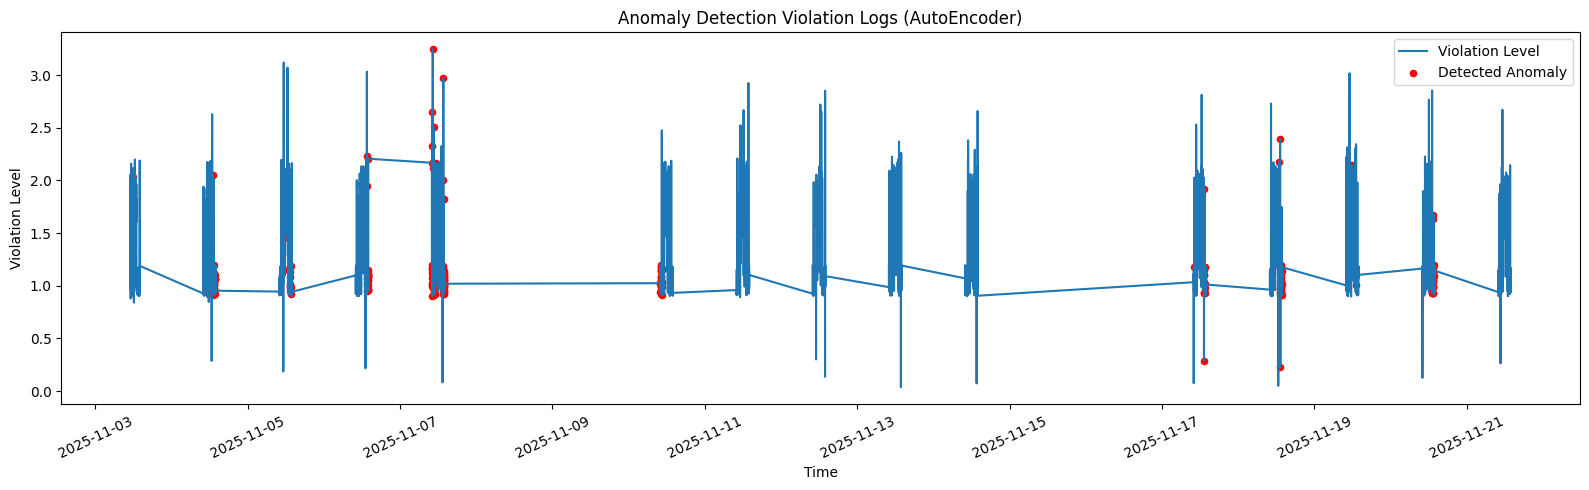

In [23]:
# 윈도우 마지막 시점에 라벨을 붙여야 함
time_index = df.index[WINDOW:]             # offset 보정된 timestamp
values_cut = df["violation_level"].values[WINDOW:]

plt.figure(figsize=(16,5))
plt.plot(time_index, values_cut, label="Violation Level")

# anomaly 표시
plt.scatter(
    time_index[labels == 1],
    values_cut[labels == 1],
    color="red",
    s=20,
    label="Detected Anomaly"
)

plt.title("Anomaly Detection Violation Logs (AutoEncoder)")
plt.xlabel("Time")
plt.ylabel("Violation Level")
plt.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()
